<a href="https://colab.research.google.com/github/elijahmflomo/Sem_2_GENERATIVE-AI/blob/main/LAB_2_GAN_(unconditional)_on_the_MNIST_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Deliverable (a): Codebase and Documentation**

*This script implements a generative model using the Minimax game logic. The Generator learns to create data, and the Discriminator learns to distinguish between real data and the Generator's output.*

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils



In [2]:
# 1. Load and Preprocess Data (Requirement A)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Normalize to [-1, 1]
])
train_loader = DataLoader(datasets.MNIST('.', train=True, download=True, transform=transform),
                          batch_size=64, shuffle=True)



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.9MB/s]


In [3]:
# 2. Define Network Architectures (Requirement B)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(100, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, 1024), nn.ReLU(),
            nn.Linear(1024, 784), nn.Tanh() # Output shape: 28x28 flattened
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 512), nn.LeakyReLU(0.2),
            nn.Linear(512, 256), nn.LeakyReLU(0.2),
            nn.Linear(256, 1), nn.Sigmoid() # Probability output
        )
    def forward(self, x):
        return self.main(x.view(-1, 784))


In [4]:

# 3. Define Loss and Optimization (Requirement C)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG = Generator().to(device)
netD = Discriminator().to(device)
criterion = nn.BCELoss()
optD = optim.Adam(netD.parameters(), lr=0.0002)
optG = optim.Adam(netG.parameters(), lr=0.0002)


In [5]:
# 4. Perform Training Loop (Requirement D)
epochs = 25
for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(train_loader):
        b_size = real_imgs.size(0)
        real_label = torch.ones(b_size, 1).to(device)
        fake_label = torch.zeros(b_size, 1).to(device)

        # (a) Train Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()
        output_real = netD(real_imgs.to(device))
        lossD_real = criterion(output_real, real_label)

        noise = torch.randn(b_size, 100).to(device)
        fake_imgs = netG(noise)
        output_fake = netD(fake_imgs.detach())
        lossD_fake = criterion(output_fake, fake_label)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optD.step()

        # (b) Train Generator: maximize log(D(G(z)))
        netG.zero_grad()
        output_g = netD(fake_imgs)
        lossG = criterion(output_g, real_label)
        lossG.backward()
        optG.step()

**Deliverable (b): Trained Models**

After training, the models are saved as state dictionaries to allow for later inference or fine-tuning.

In [6]:
torch.save(netG.state_dict(), 'generator_mnist.pth')
torch.save(netD.state_dict(), 'discriminator_mnist.pth')

**Deliverable (c): Generated Image Samples**

*The following code snippet generates a grid of 64 images using the trained Generator to demonstrate its ability to synthesize handwritten digits.*

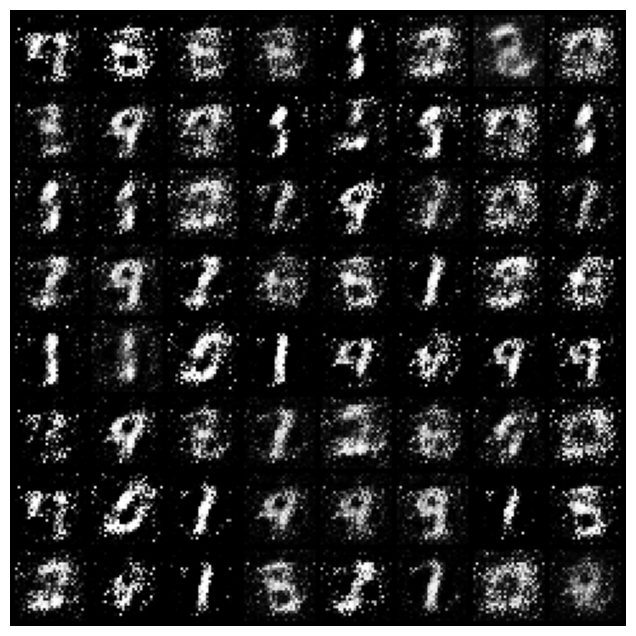

In [7]:
netG.eval()
with torch.no_grad():
    sample_noise = torch.randn(64, 100).to(device)
    samples = netG(sample_noise).cpu()

grid = vutils.make_grid(samples, padding=2, normalize=True)
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()

**Deliverable (d): Evaluation and Analysis**

1. Loss Behavior: In a successful training session, the Discriminator loss should initially drop and then fluctuate around 0.5 to 1.0. If it drops to zero, the Discriminator is "perfect," and the Generator will stop learning.

2. Visual Convergence: In the early epochs (1–5), images will look like random noise. By epoch 20, the model should produce recognizable shapes of digits (0–9), though they may be slightly blurry due to the use of fully connected layers.

3. Mode Collapse Check: If the generator produces only one type of digit (e.g., all "1"s), it has suffered from mode collapse. To fix this, you would adjust the learning rate or switch to a DCGAN (Convolutional) architecture.